In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import stats    
import math
from sklearn.decomposition import PCA
from scipy.interpolate import Rbf
import scipy.cluster.hierarchy as shc
from mpl_toolkits.mplot3d import axes3d, Axes3D
from numpy import linalg as la

In [2]:
covid=pd.read_csv("time_series_covid_19_confirmed_de.csv").drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum()
confirmed = pd.read_csv("time_series_covid_19_confirmed_de.csv").drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().loc["Germany",:]
deaths = pd.read_csv("time_series_covid_19_deaths_de.csv").drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().loc["Germany",:]
recovered = pd.read_csv("time_series_covid_19_recovered_de.csv").drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().loc["Germany",:]
infected=confirmed - deaths - recovered

Text(0,0.5,'Number of total infected cases')

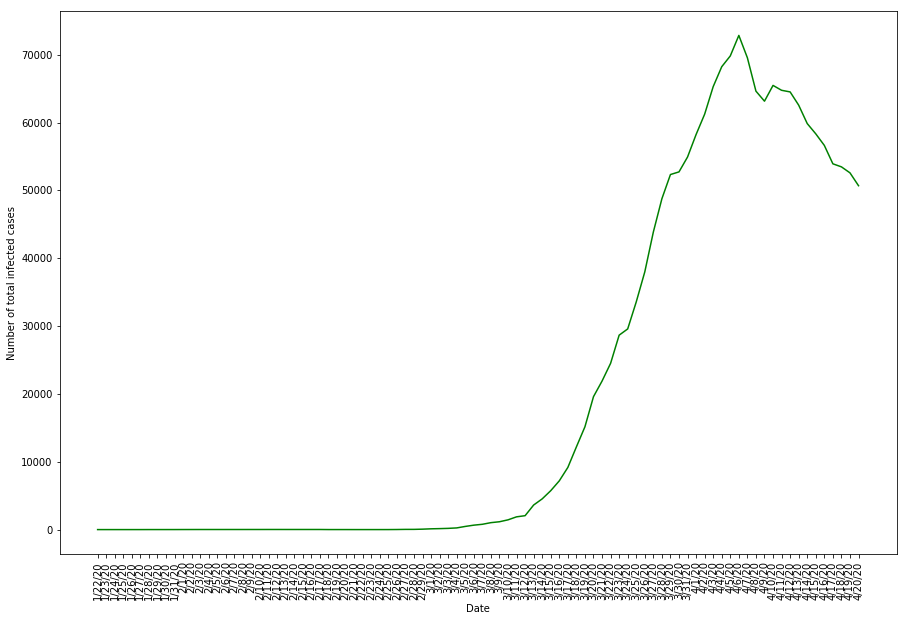

In [25]:
plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.plot(infected.values, "g-")
ax.set_xticks(np.linspace(0, len(infected)-1, len(infected)))
ax.set_xticklabels(infected.index, rotation=90)
ax.set_xlabel("Date")
ax.set_ylabel("Number of total infected cases")


Text(0,0.5,'Number of reported infected cases per day')

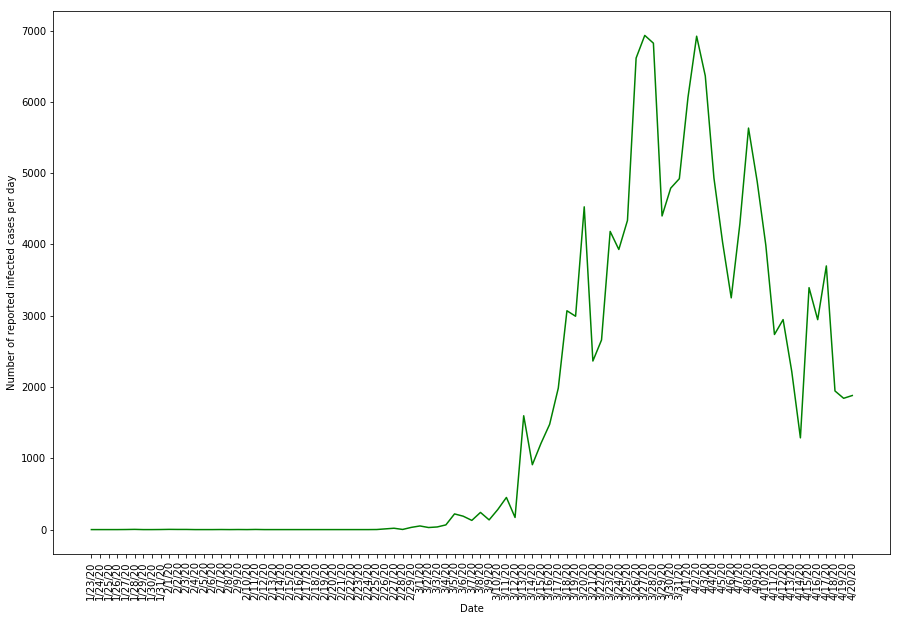

In [26]:
increment=(covid - covid.shift(periods=1, axis=1)).loc["Germany",:][1:]
plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.plot(increment.values, "g-")
ax.set_xticks(np.linspace(0, len(increment)-1, len(increment)))
ax.set_xticklabels(increment.index, rotation=90)
ax.set_xlabel("Date")
ax.set_ylabel("Number of reported infected cases per day")

### Auto-correlation of infected cases

Text(0,0.5,'Next day')

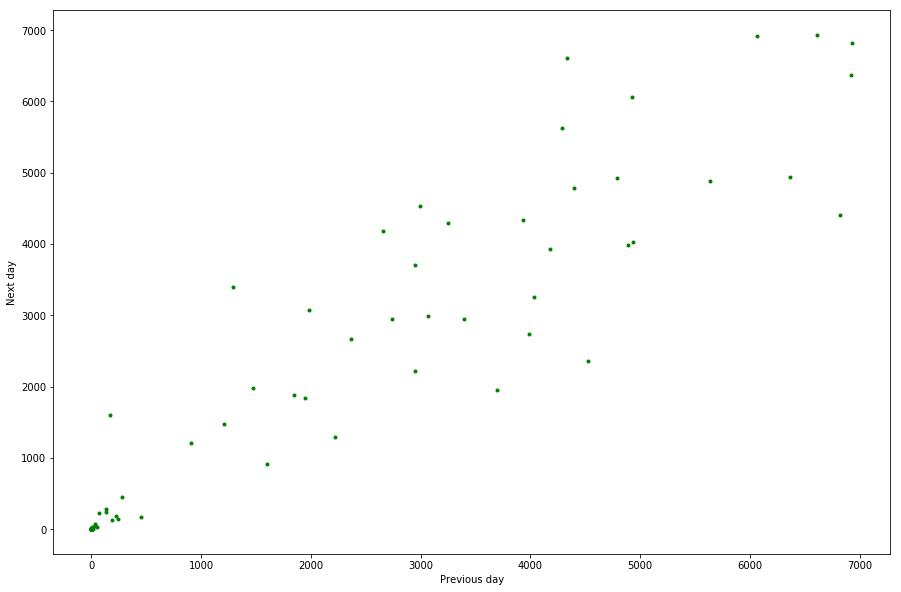

In [27]:
plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.plot(increment.values[:-1],increment.values[1:], "g.")
ax.set_xlabel("Previous day")
ax.set_ylabel("Next day")

Text(0,0.5,'Reported deaths per Day')

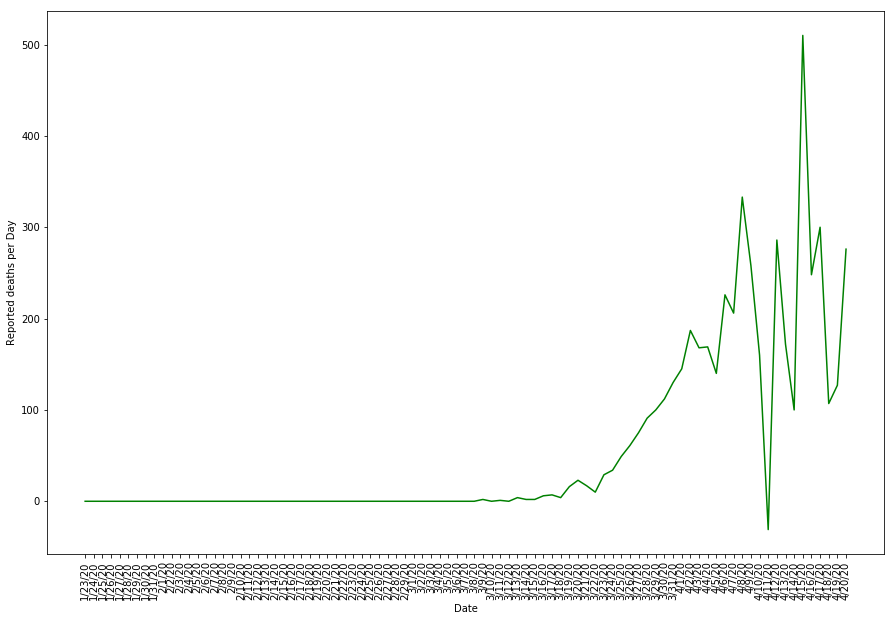

In [28]:
increment_deaths=deaths[1:].values - deaths[:-1].values
plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.plot(increment_deaths, "g-")
ax.set_xticks(np.linspace(0, len(increment_deaths)-1, len(increment_deaths)))
ax.set_xticklabels(covid.columns[1:], rotation=90)
ax.set_xlabel("Date")
ax.set_ylabel("Reported deaths per Day")

Text(0,0.5,'Number of total infected cases')

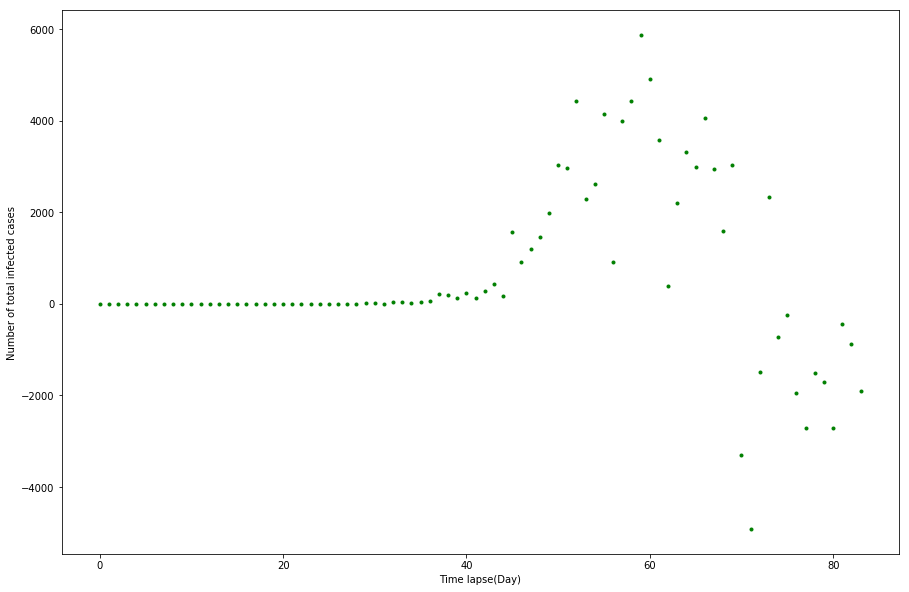

In [3]:
infected=infected[5:].values
infected_diff=infected[1:]-infected[:-1]

plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.plot(infected_diff, "g.")
ax.set_xlabel("Time lapse(Day)")
ax.set_ylabel("Number of total infected cases")


In [4]:
total = 83517045
uninfected = total - infected
uninfected_diff = uninfected[1:] - uninfected[:-1]

In [8]:
def gradient(var_sus_future, var_inf_future, var_sus, var_inf, del_sus, del_inf, total, init_coeff):
    
    grads=[2*(var_sus*var_inf/total)*(var_sus_future-var_sus+del_sus - del_inf -var_inf_future + var_inf +(4*init_coeff[0]*var_sus*var_inf/total)-2*(init_coeff[1]*var_inf)), 2*(var_inf)*(var_inf_future-var_inf+del_inf-2*init_coeff[0]*var_inf*var_sus/total + 2*init_coeff[1]*var_inf)] #All terms in the gradient vector
    

    grad=np.asarray(grads)
    '''Normalize the gradient vector because only the direction matters.'''
    grad=grad/(la.norm(grad))
    return grad


def rate(var_sus, var_inf, beta, gamma, total):
    return np.asarray([-beta*var_inf*var_sus/total, beta*var_inf*var_sus/total - gamma*var_inf])

'''Main function to train the coefficients of polynomials'''
def training(init_coeff, infected, infected_diff, uninfected, uninfected_diff, total, error, learn_rate):
    counter=0
    diff = 1
    dt = 0.01
    '''Iterate until the difference reaches the designated error.'''
    while diff > error:
        '''Solve the differential equation'''
        before = init_coeff
        for i in range(len(infected)-1):
            init_coeff=init_coeff-learn_rate*gradient(uninfected[i+1], infected[i+1],uninfected[i], infected[i], uninfected_diff[i], infected_diff[i], total, init_coeff)/math.log10(counter+2)
        after = init_coeff
        
        '''Mean residual Error (MSE)'''
        diff=la.norm(after - before)
        counter += 1
        
    return init_coeff, diff, counter

In [9]:
coeff=training([1, 1], infected, infected_diff, uninfected, uninfected_diff, total, 5*10**(-8), 0.01)[0]
coeff

array([0.02895771, 0.00558421])

Text(0,0.5,'Number of infections in real time')

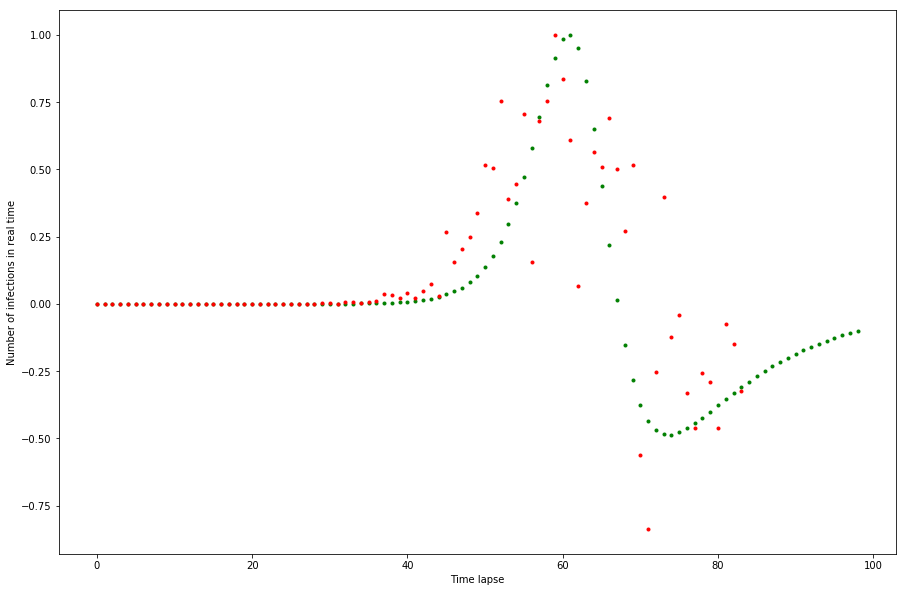

In [56]:
dt = 14.

varl = np.asarray([uninfected[0], infected[0]])
    
solutions_inf = []
for i in range(100):
    varl = varl + dt*rate(varl[0], varl[1], coeff[0], coeff[1], total)
    solutions_inf.append(varl[1])
            
solutions_inf = np.asarray(solutions_inf)
diff_solutions = solutions_inf[1:]-solutions_inf[:-1]

plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.plot(diff_solutions/np.amax(diff_solutions), "g.")

ax.plot(infected_diff/np.amax(infected_diff), "r.")
ax.set_xlabel("Time lapse")
ax.set_ylabel("Number of infections in real time")

Text(0,0.5,'Number of infections in real time')

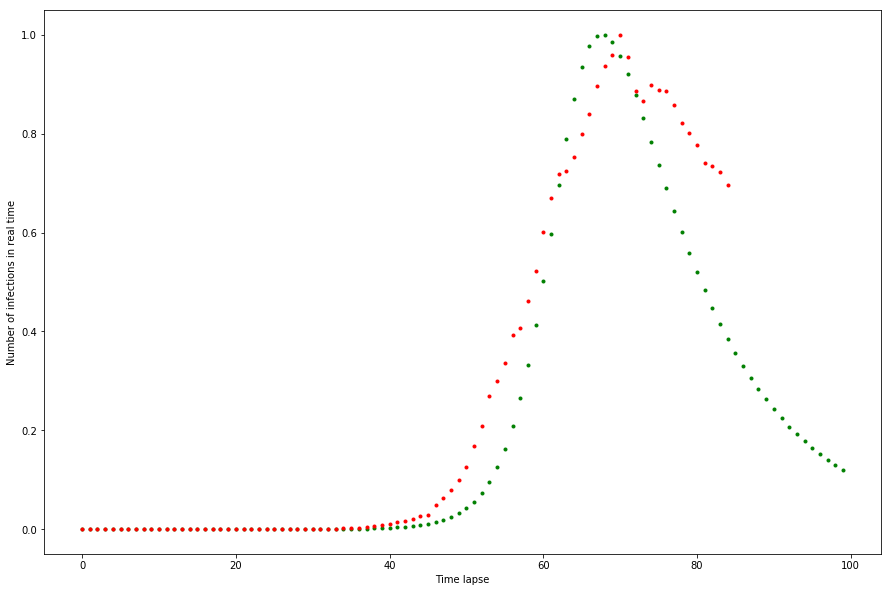

In [57]:
plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.plot(solutions_inf/np.amax(solutions_inf), "g.")
ax.plot(infected/np.amax(infected), "r.")
ax.set_xlabel("Time lapse")
ax.set_ylabel("Number of infections in real time")

In [11]:
print("R0 value is {}".format(coeff[0]/(coeff[1])))

R0 value is 5.185643063194477
